In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import sys, os
import numpy as np

WORK_PATH = "./"
SOURCE_PATH = os.path.join(WORK_PATH, "src")
sys.path.append(SOURCE_PATH)

In [40]:
from graphnics import FenicsGraph

In [55]:
import tissue, fem, visualize

TEST_GRAPH = FenicsGraph()

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],
    1: [0.010, 0.020, 0.015],
    2: [0.022, 0.013, 0.015],
    3: [0.022, 0.028, 0.015],
    4: [0.015, 0.005, 0.015],
    5: [0.015, 0.035, 0.015],
    6: [0.038, 0.005, 0.015],
    7: [0.038, 0.035, 0.015]
}

for node_id, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node_id, pos=pos)
    
TEST_GRAPH_EDGES = [
    (0, 1, 0.004),
    (1, 2, 0.003),
    (1, 3, 0.003),
    (2, 4, 0.002),
    (2, 6, 0.003),
    (3, 5, 0.002),
    (3, 7, 0.003)
]

for (u, v, radius) in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

Omega_bounds = np.array([[0, 0, 0], [0.05, 0.04, 0.03]])

mesh_builder = tissue.MeshBuild(
    TEST_GRAPH,
    Omega_bounds=Omega_bounds,
    Omega_mesh_voxel_dim=(16, 16, 16),
    Lambda_num_nodes_exp=4
)

sink_face = mesh_builder.get_Omega_axis_plane("left")

measure_builder = tissue.DomainBuild(
    mesh_build=mesh_builder,
    Lambda_inlet=[0],
    Omega_sink=sink_face
)

CUBES_TEST = fem.SubCubes(
    domain = measure_builder,
    gamma = 1.0e-6, # (can vary)
    gamma_R = 1.0e-6, # (can vary)
    gamma_a = 1.0e-6, # (can vary)
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.0e-11, # Vessel permeability in 1D (can vary)
    P_in = 100 * 133.322,
    p_cvp = 1.0 * 133.322,
    lower_cube_bounds = [[0.0,0.0,0.0],[0.01,0.01,0.01]],
    upper_cube_bounds = [[0.033, 0.03, 0.01],[0.043,0.04,0.02]]
)

Averaging over 112 cells: 100%|██████████| 112/112 [00:00<00:00, 2413.68it/s]


In [51]:
CUBES_TEST.print_diagnostics()

Flow Diagnostics
--------------------------------------------------
Sink Boundary:
  Inflow               : 0
  Outflow              : 2.408199e-05
  Net Flow (sum)       : 2.408199e-05
  Net Flow (Dolfin)    : 2.408199e-05
  --> The 'Net Flow (sum)' should equal 'Net Flow (Dolfin)'.
--------------------------------------------------
Neumann Boundary:
  Net Flow (Dolfin)    : -2.177677e-20
--------------------------------------------------
Entire Domain Boundary:
  Inflow               : -3.3304239e-06
  Outflow              : 2.7412414e-05
  Net Flow (sum)       : 2.408199e-05
  Net Flow (Dolfin)    : 2.408199e-05
  --> The 'Net Flow (sum)' should equal 'Net Flow (Dolfin)'.
--------------------------------------------------
Sum of dsOmegaNeumann and dsOmegaSink (Dolfin):
  Neumann + Sink       : 2.408199e-05
  --> This should match the net flow over the entire domain boundary.
--------------------------------------------------


Lower Cube Bounds: [[0.0, 0.0, 0.0], [0.01, 0.01, 0.01]]
Upper Cube Bounds: [[0.033, 0.03, 0.01], [0.043, 0.04, 0.02]]


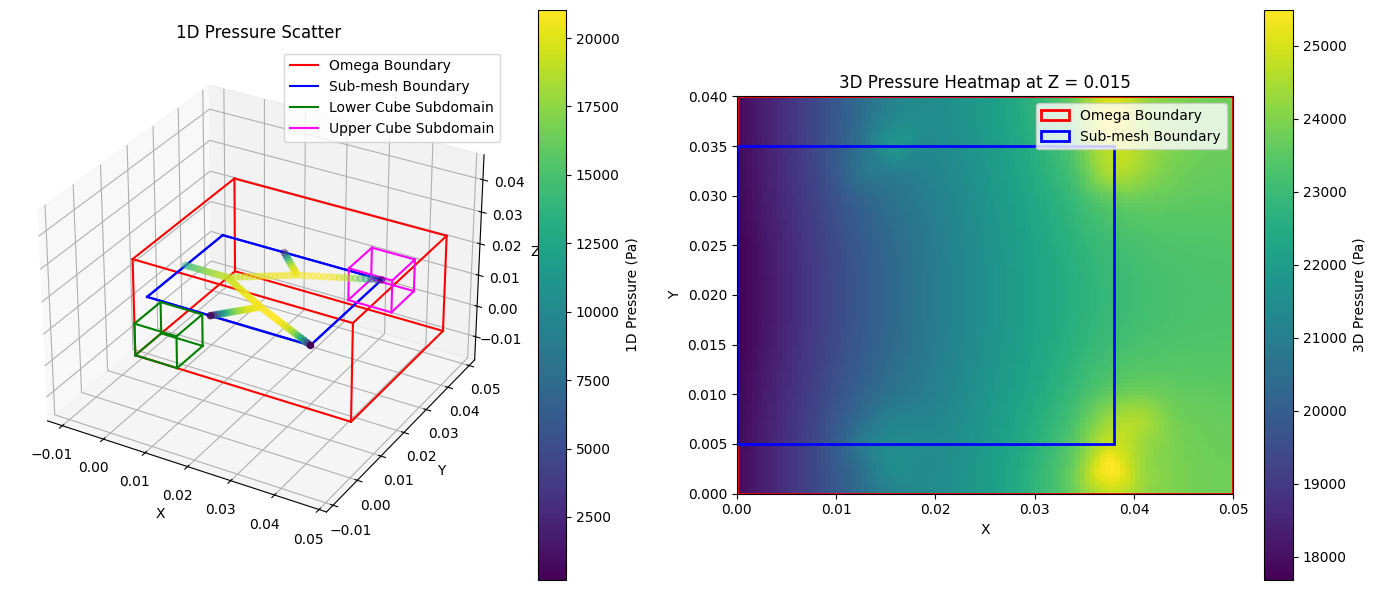

In [52]:
cube_lower_bounds = CUBES_TEST.lower_cube_bounds
cube_upper_bounds = CUBES_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

fig1 = visualize.plot_with_boundaries(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds,
     cube_upper=cube_upper_bounds)
fig1.show()

Node Pressure Data:
Node 0: Pressure 13332.2
Node 57: Pressure 14017.2
Node 29: Pressure 14628.2
Node 58: Pressure 15175.0
Node 15: Pressure 15665.9
Node 60: Pressure 16108.6
Node 30: Pressure 16509.3
Node 59: Pressure 16873.8
Node 8: Pressure 17207.0
Node 63: Pressure 17513.2
Node 32: Pressure 17796.1
Node 64: Pressure 18059.2
Node 16: Pressure 18305.5
Node 62: Pressure 18537.5
Node 31: Pressure 18757.8
Node 61: Pressure 18968.6
Node 1: Pressure 19171.7
Node 73: Pressure 19307.3
Node 37: Pressure 19431.9
Node 74: Pressure 19545.5
Node 19: Pressure 19647.9
Node 76: Pressure 19792.5
Node 38: Pressure 19940.4
Node 75: Pressure 20074.8
Node 10: Pressure 20196.4
Node 79: Pressure 20305.4
Node 40: Pressure 20401.3
Node 80: Pressure 20482.9
Node 20: Pressure 20548.6
Node 78: Pressure 20596.1
Node 39: Pressure 20622.0
Node 77: Pressure 20621.7
Node 3: Pressure 20589.3
Node 105: Pressure 20765.3
Node 53: Pressure 20886.3
Node 106: Pressure 20951.1
Node 27: Pressure 20953.9
Node 108: Pressure 2

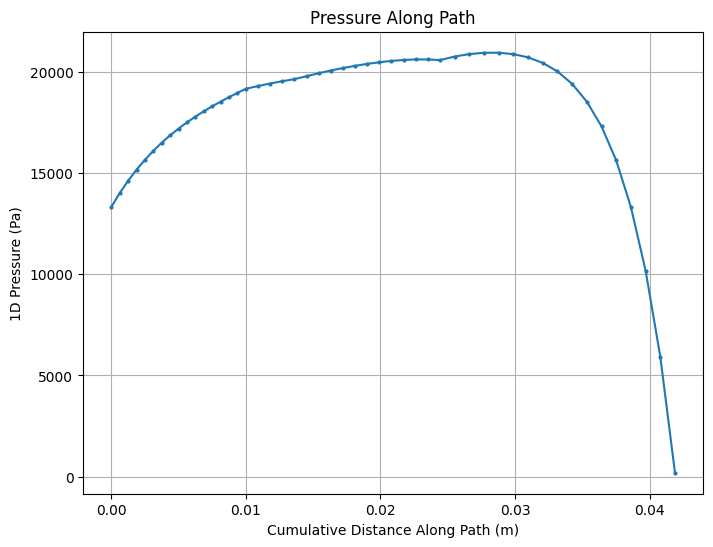

In [53]:
fig1 = visualize.plot_path_pressure(CUBES_TEST.uh1d, TEST_GRAPH, [0, 1, 3, 7])
fig1.show()

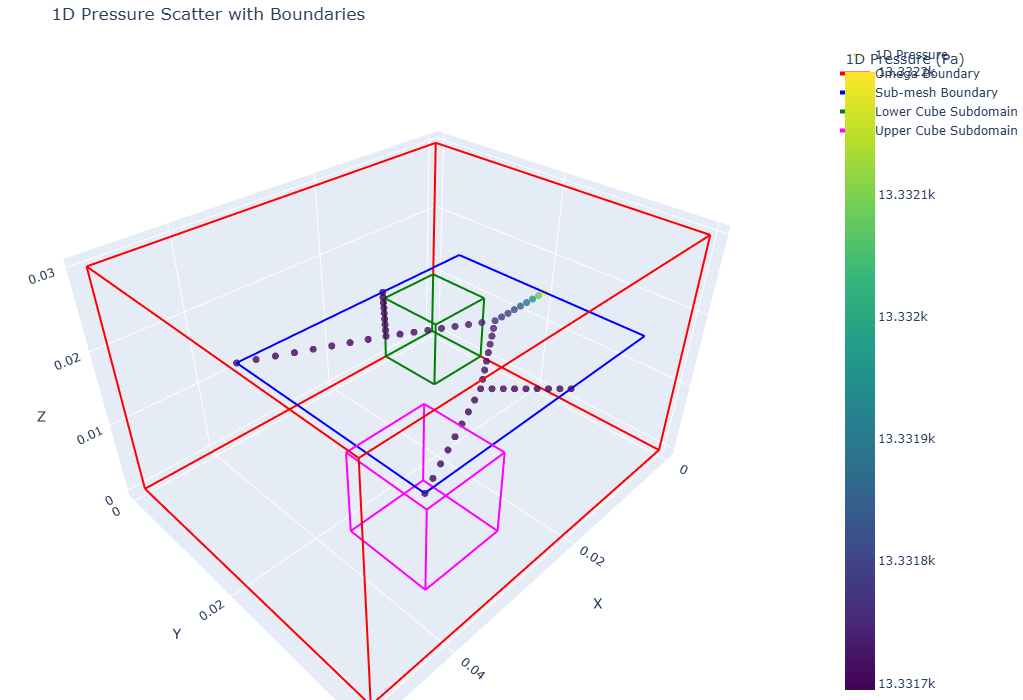

In [26]:
visualize.plot_with_boundaries_plotly(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds,
     cube_upper=cube_upper_bounds)

In [54]:
import datetime
import pytz

cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"output_{timestamp}"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBES_TEST.save_vtk(SAVE_PATH)

Averaging over 112 cells: 100%|██████████| 112/112 [00:00<00:00, 492.24it/s]


AttributeError: 'SubCubes' object has no attribute 'velocity_expr'

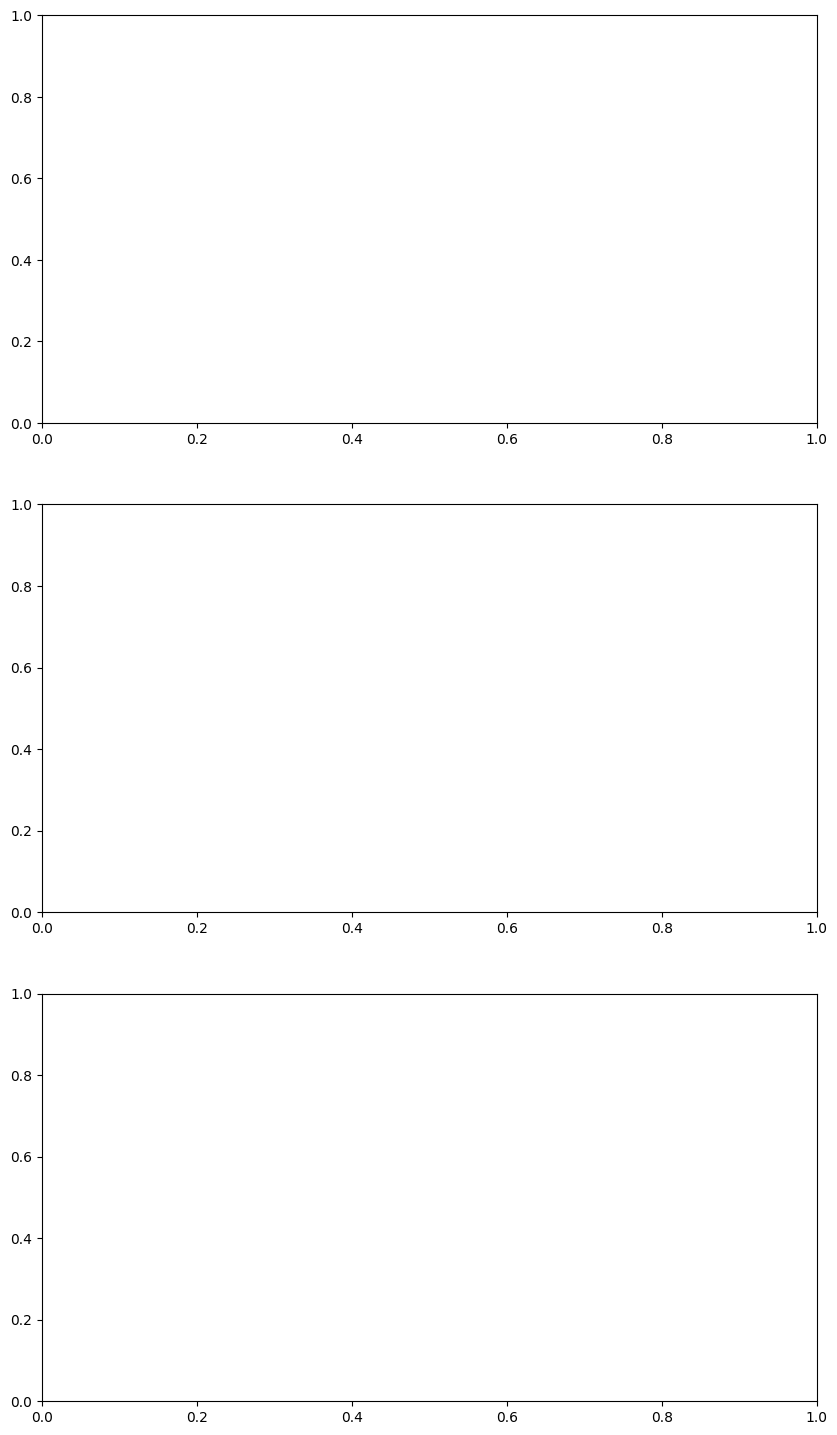

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import time

def run_sweep(param_name, values, defaults):
    fluxes = []
    for val in values:
        params = defaults.copy()
        params[param_name] = val
        cube_test = fem.SubCubes(**params)
        flux = cube_test.compute_upper_cube_flux()
        fluxes.append(flux)
    return fluxes

def vary_parameters_and_plot(num_points=50, subset_plots = ['k_t', 'gamma', 'gamma_R']):
    common_params = {
        'domain': measure_builder,
        'gamma': 1.0,
        'gamma_R': 1.0e-7,
        'gamma_a': 1.0e-10,
        'mu': 1.0e-3,
        'k_t': 1.0e-10,
        'k_v': 1.0e-8,
        'P_in': 100.0 * 133.322,
        'p_cvp': 1.0 * 133.322,
        'lower_cube_bounds': [[0.000,0.000,0.000],[0.01, 0.01, 0.01]],
        'upper_cube_bounds': _upper_cube_bounds_val
    }

    sweep_configs = {
        'k_t': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Tissue Permeability k_t",
            'title': "Upper Cube Flux vs. Tissue Permeability k_t",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma': {
            'values': np.logspace(-10, 2, num_points),
            'xlabel': "Gamma",
            'title': "Upper Cube Flux vs. Gamma",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma_R': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Gamma_R",
            'title': "Upper Cube Flux vs. Gamma_R",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        }
    }

    num_plots = len(subset_plots)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))
    if num_plots == 1:
        axes = [axes]

    for idx, param in enumerate(subset_plots):
        config = sweep_configs[param]
        values = config['values']
        fluxes = run_sweep(param, values, common_params)

        if config['plot_type'] == 'semilogx':
            axes[idx].semilogx(values, fluxes, marker='o', linestyle='-')
        else:
            axes[idx].plot(values, fluxes, marker='o', linestyle='-')

        axes[idx].set_xlabel(config['xlabel'])
        axes[idx].set_ylabel("Upper Cube Flux")
        axes[idx].set_title(config['title'])
        axes[idx].grid(True, **config['grid_kwargs'])

    plt.tight_layout()
    plt.show()

vary_parameters_and_plot(num_points=50)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1620.65it/s]


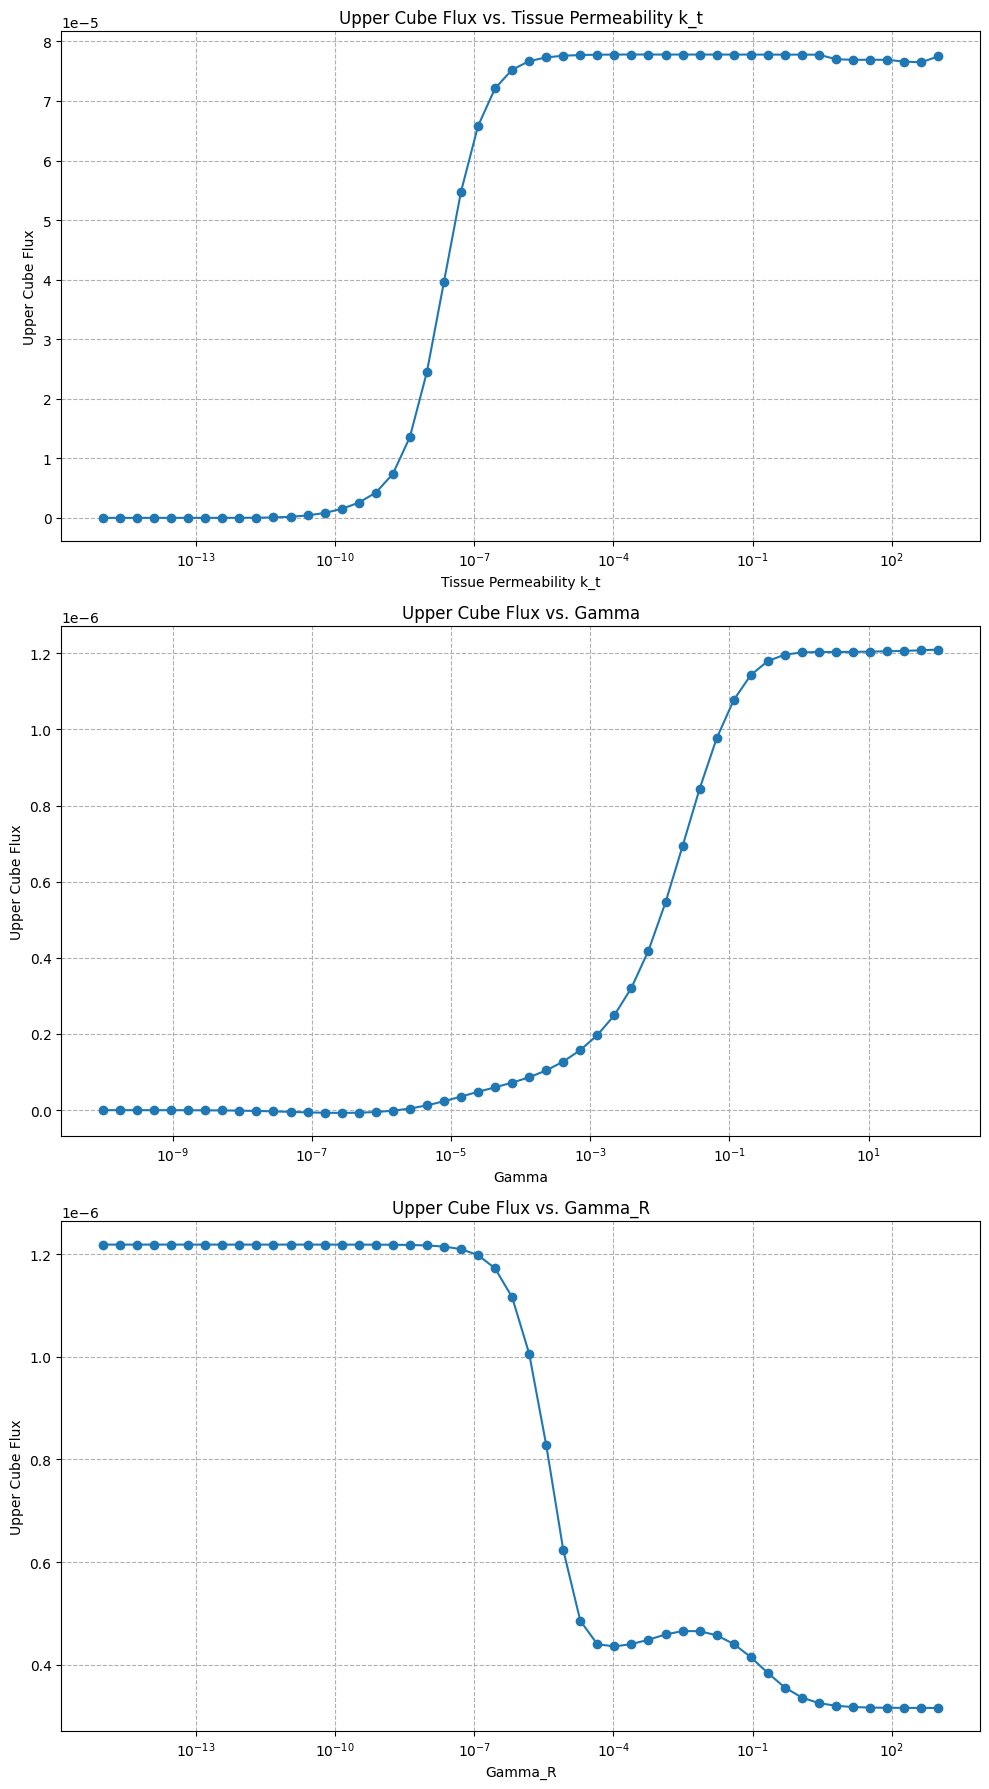

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def run_sweep_lower(param_name, values, defaults):
    fluxes = []
    for val in values:
        params = defaults.copy()
        params[param_name] = val
        cube_test = fem.SubCubes(**params)
        flux = cube_test.compute_lower_cube_flux()
        fluxes.append(flux)
    return fluxes

def vary_parameters_and_plot_lower(num_points=50, subset_plots = ['k_t', 'gamma', 'gamma_R']):
    common_params = {
        'domain': TEST_MEASURE,
        'gamma': 1.0,
        'gamma_R': 1.0e-7,
        'gamma_a': 1.0e-10,
        'mu': 1.0e-3,
        'k_t': 1.0e-10,
        'k_v': 1.0e-8,
        'P_in': 100.0 * 133.322,
        'p_cvp': 1.0 * 133.322,
        'lower_cube_bounds': [[0.000,0.000,0.000],[0.01, 0.01, 0.01]],
        'upper_cube_bounds': _upper_cube_bounds_val
    }

    sweep_configs = {
        'k_t': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Tissue Permeability k_t",
            'title': "Upper Cube Flux vs. Tissue Permeability k_t",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma': {
            'values': np.logspace(-10, 2, num_points),
            'xlabel': "Gamma",
            'title': "Upper Cube Flux vs. Gamma",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma_R': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Gamma_R",
            'title': "Upper Cube Flux vs. Gamma_R",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        }
    }

    num_plots = len(subset_plots)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))
    if num_plots == 1:
        axes = [axes]

    for idx, param in enumerate(subset_plots):
        config = sweep_configs[param]
        values = config['values']
        fluxes = run_sweep_lower(param, values, common_params)

        if config['plot_type'] == 'semilogx':
            axes[idx].semilogx(values, fluxes, marker='o', linestyle='-')
        else:
            axes[idx].plot(values, fluxes, marker='o', linestyle='-')

        axes[idx].set_xlabel(config['xlabel'])
        axes[idx].set_ylabel("Lower Cube Flux")
        axes[idx].set_title(config['title'])
        axes[idx].grid(True, **config['grid_kwargs'])

    plt.tight_layout()
    plt.show()

vary_parameters_and_plot(num_points=50)